# Reconhecimento de números (MNIST) utilizando fastai
> Tutorial utilizar o fastai para classificação do MNIST.

- toc: false 
- badges: false
- comments: true
- categories: [MNIST, fastai]
- image:

In [2]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 7.4MB/s 
     |████████████████████████████████| 51kB 7.1MB/s 
     |████████████████████████████████| 1.0MB 12.5MB/s 
     |████████████████████████████████| 61kB 8.3MB/s 
     |████████████████████████████████| 358kB 41.9MB/s 
     |████████████████████████████████| 40kB 6.2MB/s 
     |████████████████████████████████| 92kB 12.0MB/s 
     |████████████████████████████████| 61kB 9.1MB/s 
     |████████████████████████████████| 51kB 8.4MB/s 
     |████████████████████████████████| 2.6MB 48.9MB/s 
ERROR: fastai 2.0.8 has requirement pandas>=1.1.0, but you'll have pandas 1.0.5 which is incompatible.
Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis

In [3]:
#hide
from fastbook import *

Esse tutorial tem como objetivo utilizar o framework de machine learning `fastai`, para realizar um dos desafios mais tradicionais de classificação de imagens. Este é um dos desafios iniciais para os apredizes de redes neurais artificiais no que tange processamento de imagens, a base de dados utilizada para projeto pode ser encontradas em dois links diferentes:

- Kaggle: https://www.kaggle.com/c/digit-recognizer/data;
- The MNIST database: http://yann.lecun.com/exdb/mnist/.


## Carregando os pacotes utilizados

In [4]:
from fastai.vision.all import *
import numpy as np
import pandas as pd

In [ ]:
#hide
import fastai

Durante esse projeto estara sendo utilizado a versão 2.0.8 do fastai.

In [ ]:
fastai.__version__

In [5]:
#hide
from google.colab import files
uploaded = files.upload()

Saving images.zip to images.zip


In [6]:
#hide
import zipfile
with zipfile.ZipFile('/content/images.zip', 'r') as images:
  images.extractall('/content')

## Definição do caminho dos arquivos

Um ponto inicial para o projeto é a definicação de um objeto que contenha o caminho diretório das imagens, para isso será utilizada o método `Path` do fastai. Esse método não retornará somente uma `string` contendo o diretório, mas sim uma classe da biblioteca padrão do Python 3, o que torna mais fácil o acesso aos arquivos e diretórios. 


In [7]:
path = Path(r"/content/images")

## Carregando as imagens para o modelo

Para carregar as imagens para o treinamento do modelo precisamos uma função a qual determina o tipo da base de dados e como ela está estruturada. Para isso, utiliza-se a função `ImageDataLoaders`.

In [8]:
dls = ImageDataLoaders.from_folder(path, train = 'train', valid = 'valid', shuffle_train = True, bs=16)

## Definição e treinamento do modelo

Para definição da rede neural convolucional (*Convolutional Neural Network*) é utilizada a função `cnn_learner`. 

Os argumentos que serão passados para esta será:
- `dls` dataloader definido anteriormente;
- `resnet34` - arquitetura da rede neural, que neste caso está pretreinada amplamente utilizada para esse fim. Para saber mais sobre a resnet34: https://www.kaggle.com/pytorch/resnet34;
- `error_rate` - metrica utilizada para avaliação do modelo.

Afim de agilizar o treinamento do modelo, será utilizado o método `to_fp16` (*half-precision floating point*) que utilizada números menos precisos, onde é possível.

Após isso pode-se realizar o treinamento da rede neural, para isso está sendo utilizada o método `fine_tune`. Como estamos utilizando uma rede neural pre-treinada, iremos realizar 4 iterações randomicamente utilizando os parâmetros pre-treinados e depois "descongela" todos as camadas treina o modelo alterando todos os pesos.

In [9]:
from fastai.callback.fp16 import *
learn = cnn_learner(dls, resnet34, metrics=error_rate).to_fp16()
learn.fine_tune(12, freeze_epochs=4)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


Como pode-se observar no gráfico abaixo, o erro apresentado durante o trainamento decresceu até a marca de `5.27e-4` utilizando na base de dados de treinamento, o que para parece muito bom.

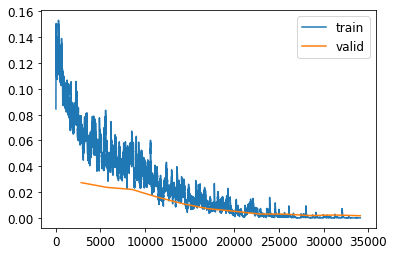

In [10]:
learn.recorder.plot_loss()

## Salvando o modelo treinado

Para salvar o modelo pode-se utilizar o método `export()`, o qual irá salvar no diretório padrão o arquivo `export.pkl`. Para carregar o modelo basta utilizar a função `load_learn()`.

In [11]:
learn.export()

In [12]:
test_images = get_image_files(path/"test",  recurse=True)

In [ ]:
#test_images.sorted(key=attrgetter(str(re.findall(r'([0-9]*)', str(item)[-6])), "name"))

test_images.sorted(key=using_attr(RegexLabeller(r'(\d*)'), 'name'))[2]

Path('/content/images/test/10.jpg')

In [13]:
pred = []
for i in range(len(test_images)):
  image_path = "/content/images/test/" + str(i) + ".jpg"
  pred.append(int(learn.predict(image_path)[0]))

In [14]:
prediction = {'ImageId': list(range(1,28001)),
              'Label': pred}

df = pd.DataFrame(prediction)
df.to_csv('predicitons.csv', index = False)